# Introduction

In this notebook we will be exploring audio data for deep learning through the Spoken Digit dataset. The goal is to get familiar with this form of data, investigate Mel-scale transformations, and examine some simple data augmentation techniques.

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_io as tfio

from IPython.display import Audio

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Spoken Digit

This dataset is analagous to the MNIST hand-written digit dataset in that it is small, simple, and digit based. In this case we are dealing with digits in audio form instead of image form. According to the documentation the data is stored in .wav files (i.e. lossless) with 8kHz sampling. There are 5 speakers with 50 recordings of each digit being spoken per speaker, so we expect 2500 samples. Let's load the dataset so that we can validate some of this information and explore further. 

Sources: [Dataset GitHub](https://github.com/Jakobovski/free-spoken-digit-dataset), [TF Datasets](https://www.tensorflow.org/datasets/catalog/spoken_digit)

We use the functionality of TensorFlow Datasets to download and load the dataset in question

In [4]:
sd_dataset, info = tfds.load('spoken_digit', split='train', 
                             shuffle_files=True, data_dir='./data', 
                             as_supervised=True, with_info=True)

We note that there is only a training split given the small size of this dataset. As well, we have downloaded the data to the *data* folder located in this same directory.

In [5]:
print(len(sd_dataset))

2500


The number of examples in our dataset matches with our expectation, now let us take a closer look at a single example.

In [6]:
for example in sd_dataset.take(1):
    print(example[0])
    print(example[1])

tf.Tensor([   0    0 -256 ... -512 -256 -512], shape=(1525,), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


We loaded our data in a supervised learning format, so each example is a tuple of (features, label). In the case above the features are a 1D tensor of integers and the label is 2. Using the IPython Audio functionality we can play this audio clip assuming the 8kHz sampling mentioned earlier.

In [7]:
Audio(example[0].numpy(), rate=8000)

Interesting, we have provided the correct sample rate as per the documentation, and I suppose the audio sounds like someone saying "two", but it certainly isn't convincing. Lets try another one, and to do this we will first transform the dataset into a pandas dataframe.

In [8]:
sd_dataframe = tfds.as_dataframe(sd_dataset, info)
sd_dataframe.head()

,audio,label
0,"[0, 0, -256, 0, -256, 0, -256, 0, 0, 0, 0, 0, ...",2
1,"[0, 0, 0, 0, -256, 0, -256, 0, -256, 0, -256, ...",1
2,"[-10, -6, -25, -20, -17, -24, -26, -30, -30, -...",9
3,"[0, 2, -3, -2, -2, -6, -1, -6, -8, -6, -8, -12...",9
4,"[-256, 0, -256, 0, 0, -256, -256, 0, -512, 0, ...",7


Great, this will just make it a little easier to deal with our data. Now we will take the fourth sample which has a label of "nine".

In [9]:
Audio(sd_dataframe.iloc[3,0], rate=8000)

Well that sounds much better as clearly the speaker is saying "nine", so I am going to conclude that some of samples might be a slightly less "clean" than others but that overall we don't have any bugs.

We have heard what the audio sounds like, but we can also visually examine the audio through its waveform.

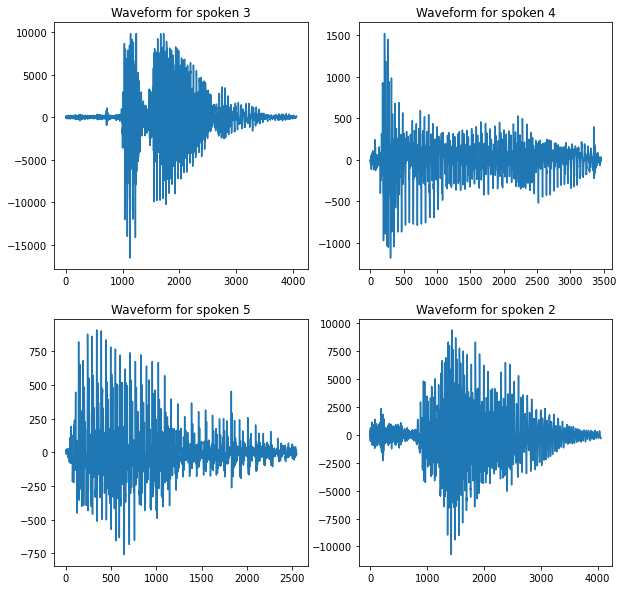

In [10]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
labels = []

for i in range(2):
    for j in range(2):
        idx = np.random.choice(sd_dataframe.shape[0])
        wave, label = sd_dataframe.iloc[idx,:]
        
        ax[i,j].plot(wave)
        ax[i,j].set_title(f'Waveform for spoken {label}')

It is certainly not obvious from these waveforms that any particular one should belong to any particular class. This isn't all that suprising, but it is interesting to think how clearly a human can unerstand the sound wave version.

One thing that I notice is the range of the waveform amplitudes range from -15000 to 10000, and depending on the example this can change dramatically. As is common in all deep learning it is most likely going to be a good idea to normalize. However, it wasn't immediately clear to me the best way to do this. In the code below I try out simple method of normalizing to $[-1,1]$ and see how it sounds.

In [11]:
audio = sd_dataframe.iloc[3,0]
audio = audio/np.max(np.abs(audio))
Audio(audio, rate=8000)

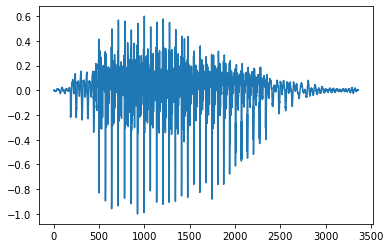

In [12]:
plt.plot(audio);

That still sounds good, but I am sure there are other methods of normalization that might have better results down the road e.g. normalizing with respect to data wide statistics. Given a clean dataset I suppose all that matters is the relative difference in a waveform, but if the data had some problems one might need to be smarter about normalization and filtering.

There are two final things I would like to check: the balancing of classes and the length of audio clips.

In [13]:
#Look at balancing
sd_dataframe.groupby('label').count().transpose()

label,0,1,2,3,4,5,6,7,8,9
audio,250,250,250,250,250,250,250,250,250,250


Perfectly balanced, and I really shouldn't expect anything less given the documentation as much as states this.

In [14]:
#Look at sequence length
sd_dataframe.iloc[:,0].apply(lambda x: len(x)).describe()

count     2500.000000
mean      3280.632000
std       1025.911437
min       1148.000000
25%       2625.500000
50%       3188.000000
75%       3813.250000
max      18262.000000
Name: audio, dtype: float64

We can see a number of statistics related to the audio clip sequence length above. The average is around 3200, but they can range from about 1150 to 18200. All this means is that some thought will have to put into model architectures so as to deal with the varying sequence length.

I was a little curious what that long audio clip sounded like, and it can be listened to below.

In [15]:
idx = np.argmax(sd_dataframe.iloc[:,0].apply(lambda x:len(x)))
Audio(sd_dataframe.iloc[idx,0], rate=8000)

Mostly it is just a slow enunciation and then silence, so nothing to worry about.

### Mel-Scale Transformations

Taking a raw audio signal and performing Mel-scale transformations is a common pre-processing step in classical machine learning and deep learning. This can provide better features for learning, and importantly it frames things the way a human would understand it. That is to say that a human's understanding of sound is complicated and non-linear, so the raw audio doesn't accurately represent what we hear.

After one transforms the signal into a Mel-spectorgram one can take the log to get the log-Mel-spectrogram, and perform a Discrete Cosine Transform to get the Mel-Frequency Cepstral Coefficients (MFCCs). These steps can further refine the features for input.

We define a function below which takes a raw audio signal as input and converts it to a Mel-spectrogram. First, we take the Short Time Fourier Transform of the signal where our frame length is 80 which implies a 10ms window as $80/8000 = 0.01$. The frame then shifts by 20 which implies we have a 75% overlap and we extract 256 FFT coefficients. Next, we use the Mel-scale filterbank to extract the Mel-spectrogram. We use 80 triangular Mel filters and we only consider frequencies in the range $[300, 4000]$.

In [2]:
def mel_spectrogram(x, length, step, rate, fft=256, mels=80, 
                    low=300, high=4000):
    s = tf.abs(tf.signal.stft(x, frame_length=length, frame_step=step, 
                       fft_length=fft))
    
    s_bins = s.shape[-1]
    
    lin2mel = tf.signal.linear_to_mel_weight_matrix(mels, s_bins, rate, 
                                                    low, high)
    
    mel_s = tf.tensordot(s, lin2mel, 1)
    
    return mel_s

Now we grab the same audio signal (of the person saying "nine") and convert it to a Mel-spectrogram.

In [74]:
audio = tf.convert_to_tensor(sd_dataframe.iloc[3,0], dtype=tf.float32)
mel_s = mel_spectrogram(audio, 80, 20, 8000)
log_ms = tf.math.log(mel_s)
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_ms)

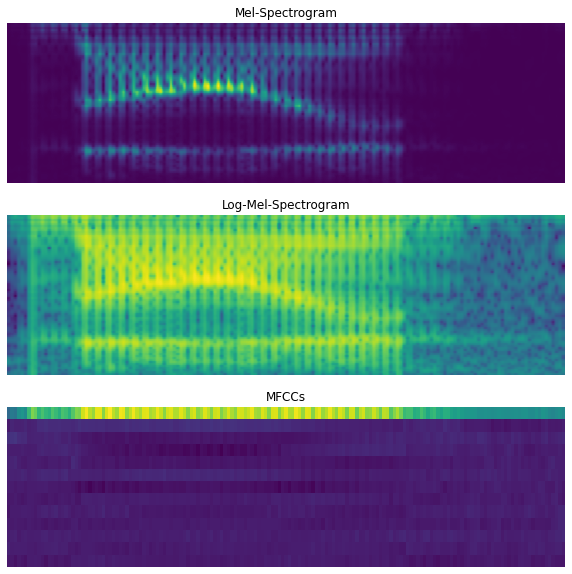

In [75]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
ax[0].imshow(tf.transpose(mel_s), aspect='auto')
ax[1].imshow(tf.transpose(log_ms), aspect='auto')
ax[2].imshow(tf.transpose(mfccs[:,:13]), aspect='auto')
ax[0].axis(False)
ax[1].axis(False)
ax[2].axis(False)
ax[0].set_title('Mel-Spectrogram')
ax[1].set_title('Log-Mel-Spectrogram')
ax[2].set_title('MFCCs');

In the plot above we see the Mel and log-Mel spectrograms as well as the first 13 MFC coefficients. I was inititally quite suprised to see that the number of important MFCCs seems very small, and this is after taking the first 13. However, it seems possible that, becuase the audio clips are short and contain only a single word, this should be an expected result. I will leave it for now, but at the end of this notebook I will try extracting the MFCCs for an audio clip of much more diverse sounds and compare. Besides this there is not too much to discuss other than noting some combination can be used as input to a network. As well, because the spectrograms are 2 dimensional, 2D convolutions can be used to process them.

### Data Augmentation

Data augmentation can be very helpful in Deep Learning and the audio realm is no exception. I will briefly go through the two most effective methods for augmentation as outlined in the SpecAugment paper discussed in class: frequency masking and time masking.

In [19]:
tfa = tfio.experimental.audio
lms = tf.transpose(log_ms)

First, we consider frequency masking where we mask a certain number of consecutive frequencies within the spectrogram.

In [20]:
f_mask = tfa.freq_mask(lms, 10)

Second, we consider time masking where we mask all frequencies for a certain number of consecutive time steps.

In [21]:
t_mask = tfa.time_mask(lms, 10)

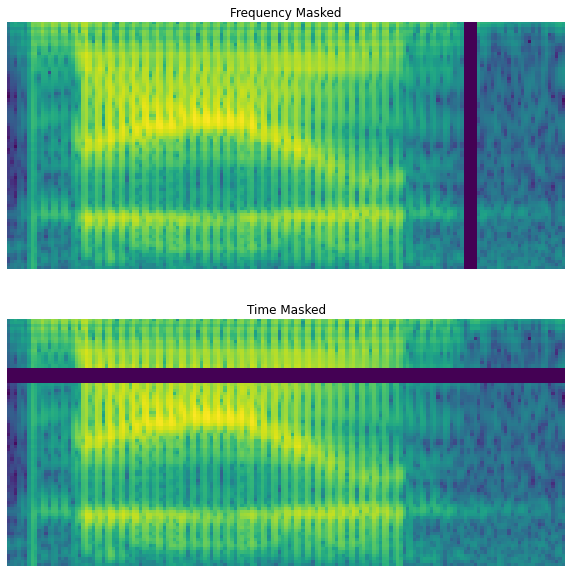

In [22]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].imshow(f_mask, aspect='auto')
ax[1].imshow(t_mask, aspect='auto')
ax[0].axis(False)
ax[1].axis(False)
ax[0].set_title('Frequency Masked')
ax[1].set_title('Time Masked');

The results of these masking operations can be seen above. Frequency is the vertical axis and time is the horizontal axis, so the results are exactly as expected.

# LibriSpeech

I had originally been planning to look at the LibriSpeech dataset as well, but I ended up spending my time elsewhere. However, I will introduce it and then examine a single example so that I can compare the MFCCs to those extracted earlier.

This dataset is much larger than Spoken Digit and is more often used in deep learning benchmarks and evaluation. The entire corpus is made up of about 1000 hours of audio from read-aloud audiobooks in English. The audio is also sampled at a higher frequency of 16 kHz (twice that of Spoken Word). Because the download size of the full dataset is roughly 60 GiB, we will only consider a small devlopment subset. This split is made up of only "clean" (i.e. not as challenging) speech and will be much easier to explore in this setting.

Sources: [Official Website](http://www.openslr.org/12), [TF Datasets](https://www.tensorflow.org/datasets/catalog/librispeech)

In [4]:
apath = './librispeech_single/84-121123-0000.flac'
tpath = './librispeech_single/84-121123.trans.txt'

In [27]:
audio = tfio.audio.AudioIOTensor(apath)
rate = audio.rate.numpy()

In [28]:
audio = audio.to_tensor()
audio = tf.squeeze(audio, axis=[-1])
Audio(audio.numpy(), rate=rate)

In [7]:
with open(tpath, 'r') as text_file:
    for line in text_file:
        loc = line.find('0000')
        if loc != -1:
            text = line[loc+5:]
            break;
            
print(f'Text label: {text}')

Text label: GO DO YOU HEAR



The label for our extracted audio is given above, and it is easy to see/hear that they match. Now lets go through the process of extracting the MFCCs from this audio clip.

In [34]:
norm = tf.cast(tf.math.reduce_max(tf.math.abs(audio)),dtype=tf.float32)
audio_norm = tf.cast(audio, dtype=tf.float32)/norm
mel_s = mel_spectrogram(audio_norm, 160, 40, 16000)
log_ms = tf.math.log(mel_s+1e-6)
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_ms)

This time I also normalized the audio waveform before processing it.

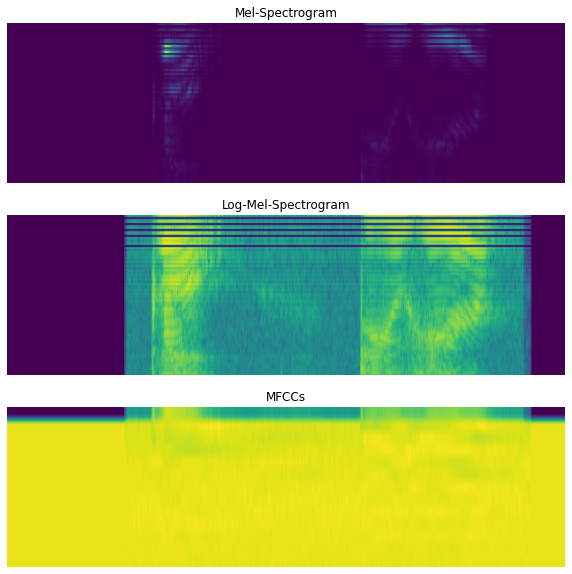

In [35]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
ax[0].imshow(tf.transpose(mel_s), aspect='auto')
ax[1].imshow(tf.transpose(log_ms), aspect='auto')
ax[2].imshow(tf.transpose(mfccs[:,:13]), aspect='auto')
ax[0].axis(False)
ax[1].axis(False)
ax[2].axis(False)
ax[0].set_title('Mel-Spectrogram')
ax[1].set_title('Log-Mel-Spectrogram')
ax[2].set_title('MFCCs');

The Mel results are shown above, and I will note that I had to add a small epsilon term to the log to avoid negative infinities. This is why some black bars can be seen horizontally in the log-Mel-Spectrogram. I believe the root of these are the silent pauses at the begining and ending of the audio clips. This also seems to be the cause of the blank regions at the beginning and ending of the spectrograms.

Moving on to the real results we can clearly see that there is more MFCC infomation in this case. We are still only taking the first 13, but it appears the more diverse audio results in more Mel-Frequency Cepstral Coefficients -- which makes sense.